**Student Name**: Karol Ziolo

**Student ID**: 20224449

# Lab 9: Planning

### Instructions: **TODO** tags
In this lab, you will implement Planning methods:
1. **DynaQ**: a model-based version of QLearning!
2. **MCTS**: the naive algo without RL; but we will understand how it fits with RL.
As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).

## Environment and useful functions
The env is the same **Windy** 4Room Environment from last time!

In [40]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy

In [41]:
class FourRoomsEnv(gym.Env):
    """ Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
        """
    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2*self.roomsize +1 # +1 is obstacle width
        self.width = self.height
        half = self.width // 2 # shortcut
        quarter = half // 2 # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))
        self. shapes = ((11,11),4)

        self.moves = {
                0: (-1, 0),  # up
                1: (0, 1),   # right
                2: (1, 0),   # down
                3: (0, -1),  # left
                }
        self.moves_to_str = {
                0: u'↑',
                1: u'→',
                2: u'↓',
                3: u'←',
                }
        
        self.terminal = (self.height-1,self.width-1) # terminal state
        horizontal  = [(i, half) for i in range(self.width)]
        vertical    = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter,half), (half,quarter), (half,self.height-quarter), (self.height-quarter,half)]:
            self.obstacles.remove(state)
        self.start = (0,0)
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))
                
        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    def is_terminal(self, state):
        return state == self.terminal
    
    def p(self, state, action):
        assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}
    
    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) not in self.obstacles:
                    ss.append((i,j))
        return ss 
    
    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        #best_qs = np.max(Qtable, axis=-1)
        values[tuple(zip(*self.obstacles))] = None # -1
        cmap = copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0,0.9)
        l[2] = np.clip(l[2], 0,0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name = 'nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap, vmin=0., vmax = 1.)
        for i in range(self.height):
            for j in range(self.width):
                s = (i,j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im, extend='both')
        plt.show()
        
class FourRoomsWindyEnv(FourRoomsEnv):    
    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]                
        # CHANGE: Apply wind. Agent might clip through walls by luck, but it's fine
        if self.s[0] < self.height//2:
            if np.random.rand() < 0.15:
                y += 1
        else:
            if np.random.rand() < 0.15:
                y -= 1
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed

            self.s = self.s[0] + x, self.s[1] + y
        

        # Finally, setting the agent back into the grid if fallen out
        self.s = (max(0, self.s[0]), max(0, self.s[1]))
        self.s = (min(self.s[0], self.height - 1),
                  min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

# 1. Stochastic DynaQ <span style="color:green"> (5 points) </span>
## 1.1 Implementation & Visual understanding
### 1.1.1 QLearning Agent
First, we're going to compare DynaQ to QLearning on a single learning attempt. We will see how they update their Q values in time, as usual. QLearning is already provided; nothing TODO here!

In [42]:
def view_train_agent(agent, env, n_episodes, plot=True, out_reward=False):
    """ Trains an agent on an env for a given amount of steps.
    If out_reward=False, returns the steps_history of the agent, i.e. number of steps each episode took.
    If out_reward=True, returns the running reward."""
    view = [0,1,3,5,10,100,500]
    agent.reset()
    # Training phase
    returns_history = np.empty(n_episodes) # all cumulative rewards during training
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        cum_r = 0 # cumulative reward
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            cum_r += reward
            if done:
                break
            s = s_
            t += 1
        if ep in view and plot:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t
        returns_history[ep] = cum_r
        
    if plot:
        print("Final Q and policy:")
        best_qs = np.max(agent.Q, axis=-1)
        greedy_policy = np.argmax(agent.Q, axis=-1)
        env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    if out_reward:
        return returns_history
    else:
        return steps_history
    
def make_plot(l, suptitle, title, xlabel, ylabel, stds,
              labels=None, interval_yaxis=None, colors=None, alphas=None):
    """ Simply saves a plot with multiple usual arguments."""
    n = len(labels)
    if colors is None:
        colors = [None]*n
    if alphas is None:
        alphas = [None]*n
    for perf, label, color, alpha, std in zip(l, labels, colors, alphas, stds):
        plt.plot(perf, label=label, color=color, alpha=alpha)
        plt.fill_between(np.arange(len(perf)), perf-std, perf+std, facecolor=color, alpha = 0.5)
            
    plt.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if interval_yaxis is not None:
        new_y1, new_y2 = interval_yaxis
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,new_y1,new_y2))
    
    plt.legend()
    plt.plot()
    
def my_random_choice(v, p=None):
    """ Faster version of the np.random.choice function with probabilities """
    if p is None:
        return v[np.random.randint(len(v))]
    # else (general case)
    assert (abs(sum(p)-1.)<1e-6), "Invalid probability vector p, sum={}".format(sum(p))
    r = np.random.rand()
    i = 0
    s = p[i]
    while s < r:
        i += 1
        s += p[i]

    if type(v) is int:
        assert len(p) == v, "Int doesn't match proba length: {} != {}".format(v, len(p))
        return i
    else:
        assert len(v) == len(p), "Incorrect entry lengths v,p: {} != {}".format(len(v), len(p))
        return v[i]

In [43]:
class QLearning():
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=.1, q0=0, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q0 = q0
        self.reset()

    def reset(self):
        self.Q = np.full((*self.input_shape, self.n_actions), self.q0, float) # Q value estimates

    def act(self, s):
        """ Epsilon-greedy policy over the Qtable """
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = my_argmax(self.Q[s])

        return action

    def learn(self, s, a, r, s_, d=False):
        self.Q[s][a] += self.alpha*(r + self.gamma*max(self.Q[s_])*(1-d) - self.Q[s][a])

In [44]:
env = FourRoomsWindyEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}

Best Q and action after episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_2769/3102021425.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


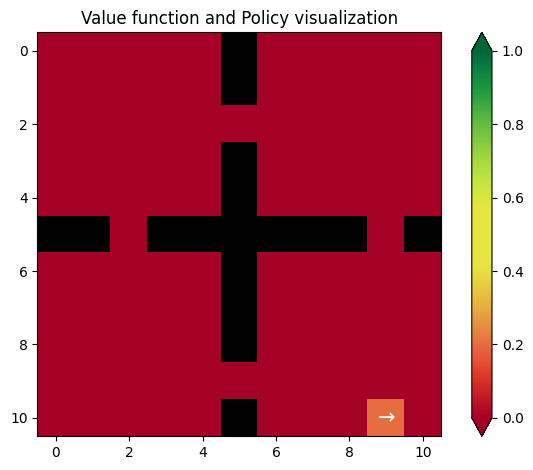

Best Q and action after episode 1:


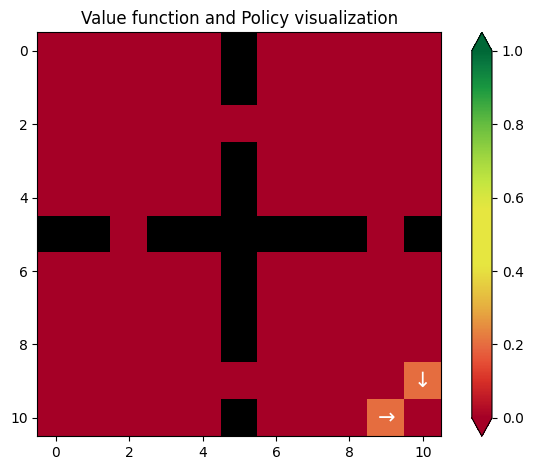

Best Q and action after episode 3:


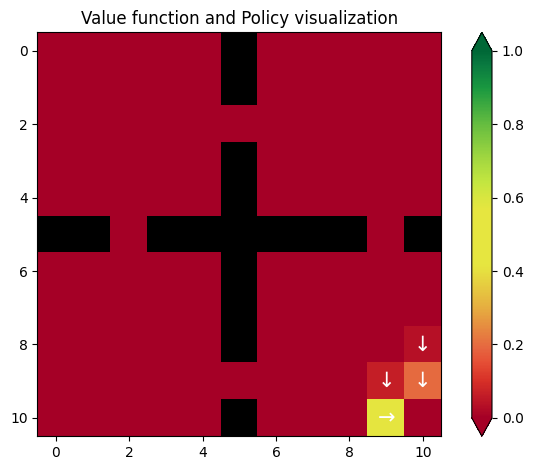

Best Q and action after episode 5:


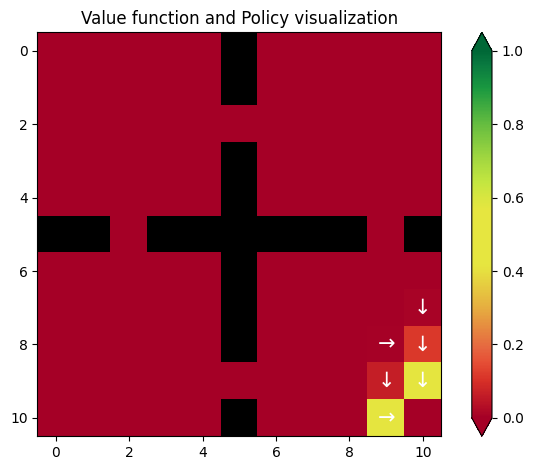

Best Q and action after episode 10:


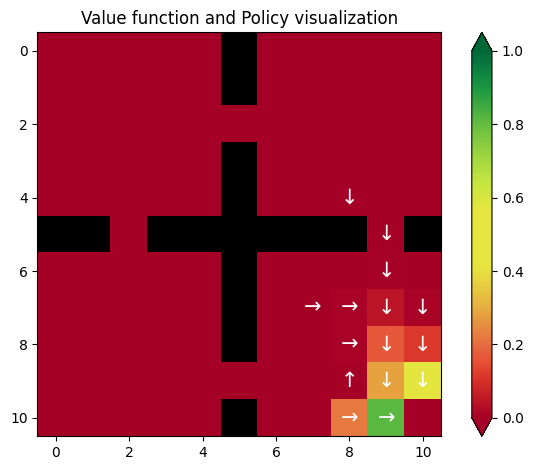

Best Q and action after episode 100:


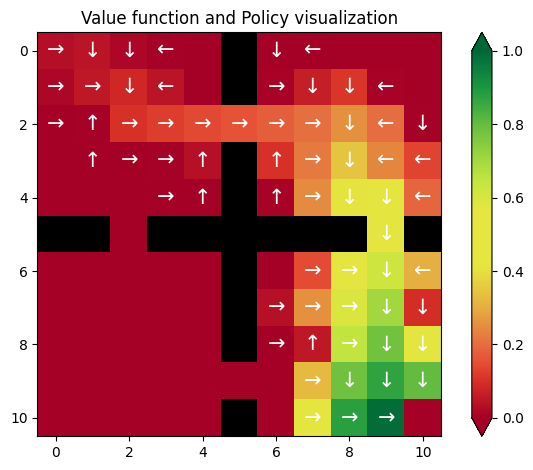

Final Q and policy:


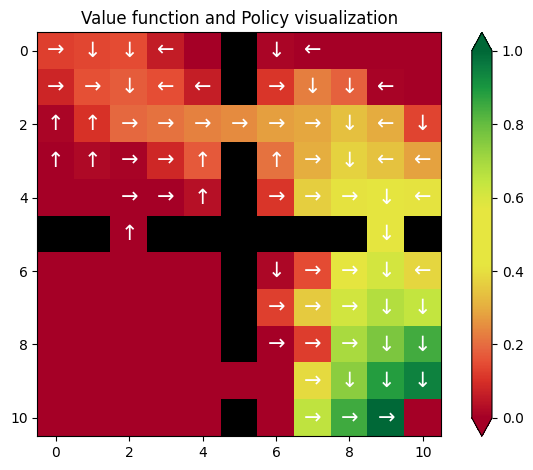

In [45]:
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 200)

### 1.1.2 <span style="color:blue"> **TODO** </span> DynaQ
Now you have to implement DynaQ. It is composed of two main parts: first, the model, which can be thought of as a completely independent module that simply approximates the dynamics. Second, the agent, based on QLearning, but that makes use of the model according to the course algo.

Be careful, we have a **stochastic** environment! Don't implement a dererministic model!
When sampling from the model, you want to sample transitions according to how probable they are. In other words, you pick a state-action pair random and uniformly over what you have observed, but you sample the nextstate-reward pair according to your approximate dynamics.

In [46]:
from collections import defaultdict
import random
class Model():
    def reset(self):
        # TODO
        self.action_state = {}
        self.all = {}
    def learn(self, s,a,r,s_,d):
        if (s, a) not in self.action_state.keys():
            self.action_state[(s, a)] = 1 
        else:
            self.action_state[(s, a)] += 1
 
        if (s, a, r, s_, d) not in self.all.keys():
            self.all[(s, a, r, s_, d)] = 1 
        else:
            self.all[(s, a, r, s_, d)] += 1
    
    def sample(self):
        # TODO
        probs = []
        vals = []
        (state, action) = random.choice(list(self.action_state.keys()))
        for s, a, r, s_, d in self.all:
            if (state, action) == (s, a):
                vals.append((s, a, r, s_, d))
                probs.append(self.all[(s, a, r, s_, d)] / self.action_state[(s, a)])
        s,a,r,s_,d = my_random_choice(vals, probs)
        return s,a,r,s_,d
    
class DynaQ(QLearning):
    def __init__(self, n, **kwargs):
        self.n = n # number of steps of planning per learning step
        self.model = Model()
        super(DynaQ, self).__init__(**kwargs) # inits shapes
        
    def reset(self):
        # TODO
        super().reset()
        self.model.reset()
    def learn(self, s, a, r, s_, d=False):
        # TODO
        super().learn(s, a, r, s_, d)
        self.model.learn(s, a, r, s_, d)
        for i in range(self.n):
            s_i, a_i, r_i, s_i_, d_i = self.model.sample()
            super().learn(s_i, a_i, r_i, s_i_, d_i)

Best Q and action after episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_2769/3102021425.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


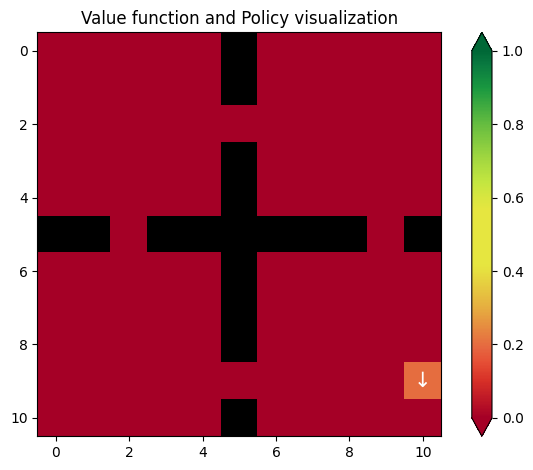

Best Q and action after episode 1:


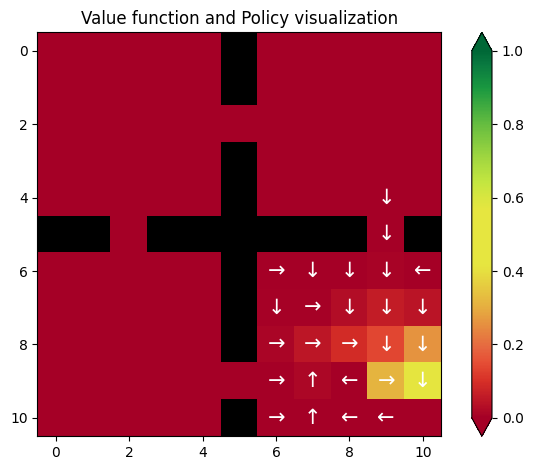

Best Q and action after episode 3:


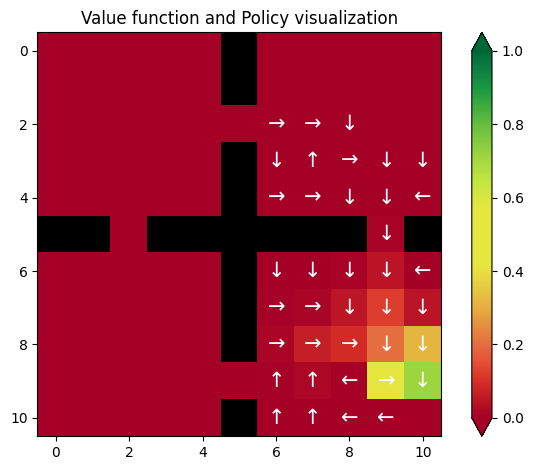

Best Q and action after episode 5:


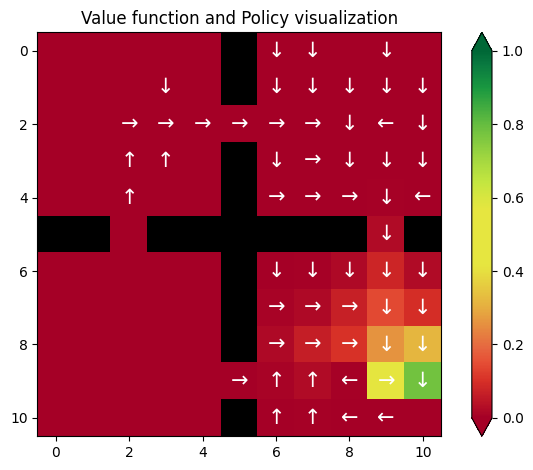

Best Q and action after episode 10:


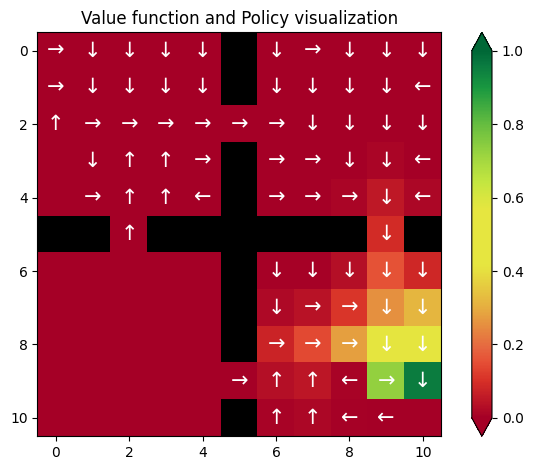

Best Q and action after episode 100:


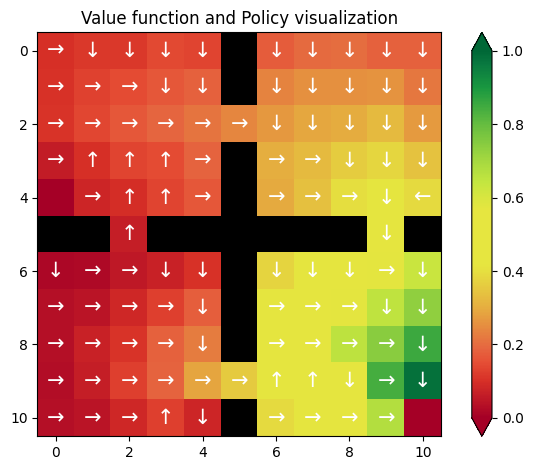

Final Q and policy:


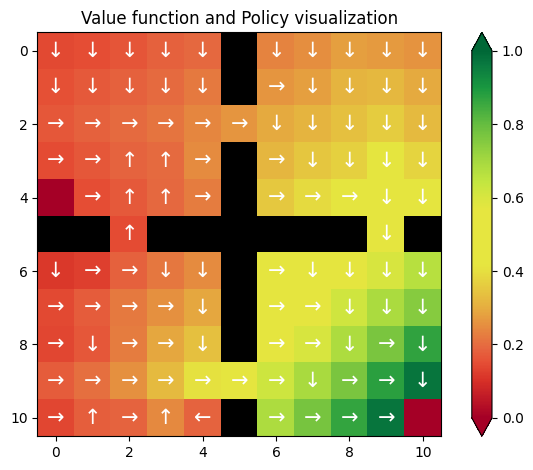

In [47]:
env = FourRoomsWindyEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
    'n' : 5
}

agent = DynaQ(**d)
perf_ql = view_train_agent(agent, env, 200)

<span style="color:red"> **TODO** </span> Describe and explain your results.

Here, we observe that DynaQ provides a more accurate depiction of the graphs compared to QL. This is because DynaQ takes into account all potential states and actions within a specific model across various episodes. On the other hand, QL only focuses on the current state and action, relying heavily on the model's exploration in that particular episode. Consequently, DynaQ furnishes us with a greater amount of information when compared to QL.

## 1.2 <span style="color:red"> **TODO** </span> Empirical behavior
This was a visual understanding, with little scientific value in practice. Let's compare both our algorithms over many seeds and see how they perform in average!

In [48]:
import time
def multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = view_train_agent(agent, env, n_episodes, plot=False)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(perfs, 0), np.std(perfs, 0)

from multiprocess import Pool
def single_process(agent, env, n_episodes, n_s, n_p):
    out = []
    for i in range(n_s//n_p):
        out.append(view_train_agent(agent, env, n_episodes, plot=False))
    return out

def parallel_multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    n_p = 5
    with Pool(n_p) as p:
        outs = p.starmap(single_process, [[agent, env, n_episodes, n_s, n_p]]*n_p)
    outs = np.concatenate(outs, 0)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(outs, 0), np.std(outs, 0)

def smooth_fast(y, box_pts):
    n = len(y)
    ws = 2*box_pts +1
    y_smooth = []
    for i,yi in enumerate(y):
        if i < box_pts:
            y_smooth.append(None)
        elif i == box_pts:
            y_smooth.append(np.mean(y[i-box_pts:i+box_pts+1]))
        elif i < n - box_pts:
            y_smooth.append(y_smooth[i-1] + (y[i + box_pts] - y[i - box_pts - 1])/ws)
        elif i < n:
            y_smooth.append(None)

    return np.array(y_smooth, dtype=np.float)

In [49]:
n_episodes = 200
n_s = 100
d['epsilon'] = 0.1

In [50]:
# QLearning:
agent = QLearning(**d)
perf_ql, std_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 2.0151190757751465s


In [51]:
# DynaQ:
agent = DynaQ(**d)
perf_dyna, std_dyna = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 46.02013683319092s


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_2769/599857768.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(y_smooth, dtype=np.float)


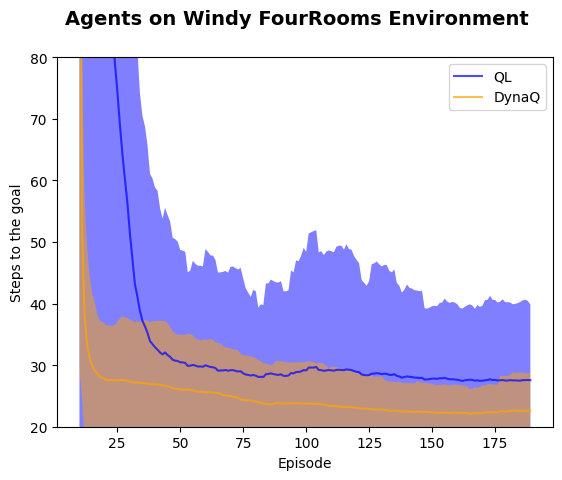

In [52]:
smooth_perf_ql = smooth_fast(perf_ql, 10)
smooth_std_ql = smooth_fast(std_ql, 10)

smooth_perf_dyna = smooth_fast(perf_dyna, 10)
smooth_std_dyna = smooth_fast(std_dyna, 10)

make_plot([smooth_perf_ql, smooth_perf_dyna], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['QL', 'DynaQ'], interval_yaxis=(20,80),
          colors=['blue', 'orange'],
          alphas=[0.7]*2,
          stds=[smooth_std_ql, smooth_std_dyna])

<span style="color:red"> **TODO** </span> Describe and explain your results.

The results above strongly indicate that DynaQ takes significantly less steps than QL. The reason behind that is the fact that DynaQ is able to incorporate simulated experience. However, the Q-learning learns only from the real interactions with the environment to update its Q-values. In other words DynaQ combines real experience with planning steps. Therefore it can explore and learn from a wider range of scenarios. 


# 2. Tic Tac Toe Agent: MCTS <span style="color:green"> (5 points) </span>

AlphaZero, and all its successors, use MCTS as its basis for planning. Where DynaQ only uses its model to learn, MCTS uses the model to perform its next actions. It order to do this, it tries to explore the most relevant part of the upcoming state-space. The course makes a nice explanation of the algo!

## 2.1. Tic Tac Toe Environment
We will sadly not be solving chess in this lab. Instead, we'll focus on Tic Tac Toe.

In [53]:
import gym
from gym import spaces
import numpy as np


class TicTacToeEnv(gym.Env):
    def __init__(self):
        """ Sets the initial state board and players.
            We use a simple np array for the board.
            """
        self.player = 1
        self.opponent = -1
        self.empty = 0
        self.trans = {self.player:  [1,0],
                      self.opponent:[0,1],
                      self.empty:   [0,0]} # transformation dict for nn input
        self.width = 3
        self.height = 3
        self.action_space = spaces.Discrete(self.height*self.width)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))

    def switch_player(self):
        """ Player becomes opp, and reverse.
            """
        self.player, self.opponent = self.opponent, self.player

    def move(self,move):
        """ Checks the validity of the move first.
            Current 'player' performs the move, and it is the opponent to move.
            """
        assert move in self.legal_actions(), "Non legal move :" + str(move)

        self.fields.ravel()[move] = self.player
        self.switch_player()

    def legal_actions(self):
        """ Returns the set of legal moves in this state.
            Empty if none.
            """
        return np.flatnonzero(self.fields.ravel() == self.empty)

    def random_move(self):
        """ Returns a random move in this position.
            The move is NOT played.
            """
        return np.random.choice(self.legal_actions())

    def render(self):
        """ Prints the board (a numpy array)
            """
        print(self.fields)

    def reset(self):
        """ Gym-like method : resets the board to emptiness,
            returns the state.
            """
        self.player = 1
        self.opponent = -1
        self.fields = np.zeros((self.height, self.width), np.int8)
        return self.fields

    def copy_other(self, other):
        """ Gives this instance the value of another TicTacToeEnv instance.
            """
        assert isinstance(other, TicTacToeEnv), "can't copy a non-TicTacToeEnv."
        self.fields = other.fields.copy()
        self.player, self.opponent = other.player, other.opponent

    def make_copy(self):
        """ Returns a copy of this TicTacToeEnv instance.
            """
        c = TicTacToeEnv()
        c.fields = self.fields.copy()
        c.player, c.opponent = self.player, self.opponent
        return c

    def get_fields(self):
        """ Returns a copy of this instance's fields.
            """
        return self.fields.copy()

    def won(self):
        """ Returns whether the last move was winning.
            Checks the opponent's pieces since they moved last.

            Probably not the fastest solution.
            """
        if any(np.sum(self.fields, axis=0) == 3*self.opponent):
            return True
        if any(np.sum(self.fields, axis=1) == 3*self.opponent):
            return True
        if np.trace(self.fields) == 3*self.opponent:
            return True
        if ((self.fields[0,2] + \
             self.fields[1,1] + \
             self.fields[2,0]) == 3*self.opponent):
            return True
        return False

    def step(self, action):
        """ Gym-like method for a move in the environment.
            Point is to return the reward (-1,0,1) as the game winner.
            Also returns the board and a boolean for game ending.
            """
        self.move(action)
        obs = self.fields.reshape((self.height, self.width))
        done = self.won()
        reward = self.opponent if done else 0 # already switched
        if not any(self.legal_actions()) and not done:
            done = True
            reward = 0
        info = {}
        return obs, reward, done, info


In [54]:
env = TicTacToeEnv()

Let's see if the environment makes sense:

In [55]:
env.reset()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int8)

In [56]:
env.step(0)

(array([[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int8),
 0,
 False,
 {})

In [57]:
env.render()

[[1 0 0]
 [0 0 0]
 [0 0 0]]


In [58]:
env.step(5)

(array([[ 1,  0,  0],
        [ 0,  0, -1],
        [ 0,  0,  0]], dtype=int8),
 0,
 False,
 {})

In [59]:
env.step(6)

(array([[ 1,  0,  0],
        [ 0,  0, -1],
        [ 1,  0,  0]], dtype=int8),
 0,
 False,
 {})

In [60]:
env.step(4)

(array([[ 1,  0,  0],
        [ 0, -1, -1],
        [ 1,  0,  0]], dtype=int8),
 0,
 False,
 {})

In [61]:
env.step(2)

(array([[ 1,  0,  1],
        [ 0, -1, -1],
        [ 1,  0,  0]], dtype=int8),
 0,
 False,
 {})

In [62]:
env.step(3)

(array([[ 1,  0,  1],
        [-1, -1, -1],
        [ 1,  0,  0]], dtype=int8),
 -1,
 True,
 {})

The episode ends (done=True) with reward -1: the second player has won!

## 2.2 Random Agent
Let's pitch random agents again each other at Tic Tac Toe!

In [63]:
class Random_Agent:
    def act(self, env): # In this scenario we assume knowledge of the environment!
        return my_random_choice(env.legal_actions())

In [64]:
# Tournament!
def convert(player_start, reward):
    player_start = 2*player_start - 1 # player0 is -1; player1 is +1
    return player_start*reward+1 # player start was player1 (+1), lost, hence -1, so player0 won, so index 0 
    
players = [Random_Agent(), Random_Agent()]
def tournament(env, players, n_games):
    results = [0,0,0]
    for game in range(n_games):
        state = env.reset()
        #env.render()
        current_player = game%2
        player_start = current_player
        while True:
            action = players[current_player].act(env)
            next_state, reward, done, _ = env.step(action)
            #env.render()
            if done:
                break
            state = next_state
            current_player = 1-current_player # switch players

        results[convert(player_start, reward)] += 1
    return results

In [65]:
n_games = 1000
results = tournament(env, players, n_games)
print(f"[wins of agent0; draws; wins of agent1] over {n_games} games: {results}")

[wins of agent0; draws; wins of agent1] over 1000 games: [431, 161, 408]


## 2.3 <span style="color:blue"> **TODO** </span> MCTS Agent
MCTS really shines when it has a prior policy to control which actions to dive into, and a value function to estimate the value of the states when stopping the search.

However, we have none of these now. What we will be doing instead is use the two most naive forms of a policy and value function we can:
- no prior policy
- a random rollout policy
- a MC estimate for the value functions; in other words, the outcome of the rollout policy.

MCTS is really quite tricky to implement, so I'll try to provide useful parts of the code.

In [255]:
c = 2.
gamma = 0.9
class Node():
    def __init__(self, env, parent, reward=0, done=False):
        self.env_state = env.make_copy()
        self.is_terminal = done
        self.player = self.env_state.player
        self.reward = reward
        self.legal_actions = list(self.env_state.legal_actions())
        self.a_counts = {a:0 for a in self.legal_actions}
        self.V = 0
        self.children = {a:None for a in self.legal_actions}
        self.parent = parent
        self.visits = 0
    
    def tree_policy(self):
        assert not self.is_terminal
        global c
        # TODO
        # print(f"Legal actions: {self.legal_actions}")  # Debug print
        if self.visits == 0:
            return np.random.choice(self.legal_actions)
        else:
            UCB = {
                a: self.V + c * np.sqrt(np.log(self.visits) / (1 + self.a_counts[a]))
                for a in self.legal_actions
            }
            max_value = max(UCB.values())
            best_actions = [a for a in self.legal_actions if UCB[a] == max_value]
            if len(best_actions) == 0:
                return np.random.choice(self.legal_actions)
            else:
                return np.random.choice(best_actions)
    
    def add_child(self, a):
        assert not self.is_terminal
        assert a in self.legal_actions, f"Action {a} in state {self} {self.env_state.render()}"
        new_env = self.env_state.make_copy()
        _, reward, done, _ = new_env.step(a)
        self.children[a] = Node(new_env, self, reward, done)
        self.legal_actions.remove(a)
        self.visits += 1
        self.a_counts[a] += 1
        if len(self.legal_actions) == 0:
            self.is_terminal = True
    
    def backup(self, G):
        global gamma
        self.V = (1 - gamma) * self.reward + gamma * G
    
    def __str__(self):
        return f"Node: {id(self)}\n \
                 {self.env_state.render()}\n \
                 Visits: {self.visits}\n \
                 Reward: {self.reward}\n \
                 V={self.V}"
        
class MCTS_Agent():
    def __init__(self, rollouts):
        self.rollouts = rollouts
        self.rollout_policy = Random_Agent()
        self.c = c
        self.gamma = gamma

    def act(self, env):
        self.current_node = Node(env, None) # No parent: root node
        for r in range(self.rollouts):
            node = self._selection()
            if not node.is_terminal:
                action = node.tree_policy()
                self._expansion(node)
                G = self._simulation()
                self._backup(G)
        a = self._final_decision()
        return a
    
    def _final_decision(self):
        # TODO: most visited action
        max_visit = max(self.current_node.a_counts.values())
        most_visited_actions = [a for a, count in self.current_node.a_counts.items() if count == max_visit]
        return np.random.choice(most_visited_actions)

    def _selection(self):
        node = self.current_node
        while not node.is_terminal and all(node.children[a] is not None for a in node.legal_actions):
            exploration_values = {
                a: self._calculate_ucb(node, a)
                for a in node.legal_actions
            }
            best_action = max(exploration_values, key=exploration_values.get)
            node = node.children[best_action]
        return node
        
    def _calculate_ucb(self, node, action):
        assert action in node.legal_actions, f"Action {action} not in legal actions"
        exploration_term = self.c * np.sqrt(np.log(node.visits) / (1 + node.a_counts[action]))
        return node.V + exploration_term
    
    def _expansion(self, node):
        assert node is not None, "Selected node is None"
        legal_actions = node.legal_actions
        a = np.random.choice(legal_actions)
        node.add_child(a)

    def _simulation(self):
        env = self.current_node.env_state.make_copy()
        done = False
        while not done:
            action = self.rollout_policy.act(env)
            _, reward, done, _ = env.step(action)
        G = reward
        return G

    def _backup(self, G):
        node = self.current_node
        while node is not None:
            node.visits += 1
            node.reward += G
            node = node.parent


In [256]:
players = [MCTS_Agent(100), Random_Agent()]
n_games = 100
results = tournament(env, players, n_games)

print(f"Number of wins of each agent over {n_games} games: {results}")

Number of wins of each agent over 100 games: [45, 16, 39]


<span style="color:red"> **TODO** </span> Are you doing better than the Random Policy? Remind the strengths and weaknesses of the MCTS you have implemented.

It seems that it is better. The strength of MCTS is that it uses Monte Carlo simulations to sample and explore the game tree. Also it keeps balance between exploration of unexplored moves and exploitation of known good moves through its tree policy. However, there are some weaknesses which is for example low knowledge about the game tree ate the beginning of the search. It is also quite expensive in terms of computation complexity.


<span style="color:red"> **TODO** </span> We want to further improve on this agent using function approximation through Deep Neural Networks. How would you do it?

I would create a naural network architecture where the input would be the state representation and the output would be predicted action value for each possible action. Then I would collect data and train the neural network. Afterwards  in the MCTS algorithm instead of using immediate rewards for updates I would use predicted values from neural network. 